# Create Simple Neural Network with PyTorch 

In [1]:
# PyTorch is an open source machine learning library based on the Torch 
# library, used for applications such as computer vision and natural language 
# processing, primarily developed by Facebook's AI Research lab.
# Torch is an open-source machine learning library, a scientific computing 
# framework, and a script language based on the Lua programming language.
import torch
import numpy as np 
import matplotlib.pyplot as plt

## Task 1 : Loading and Visualizing MNIST Dataset 

In [2]:
# torchvision is a library of PyTorch. It consist of popular datasets, 
# model architectures, and common image transformations for computer vision.
from torchvision import datasets, transforms as T

# Transforms are common image transformations. 
# They can be chained together using Compose.
# ToTensor: Converts a PIL (Python Image Library, or Pillow) Image or numpy.ndarray 
# (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) 
# in the range [0.0, 1.0] if the PIL Image belongs to one of the modes 
# (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype 
# = np.uint8.
# Normalize: Normalize a tensor image with mean and standard deviation.
# Mean and std are sequences for each channel.
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

In [3]:
# train: If True, creates dataset from training.pt, otherwise from test.pt.
# Returns image and label.
trainset = datasets.MNIST('MNIST_data/', download = False, train = True, transform = transform)
testset = datasets.MNIST('MNIST_data/', download = False, train = False, transform = transform)

In [4]:
print("Size of trainset: {}".format(len(trainset)))
print("Size of testset: {}".format(len(testset)))

Size of trainset: 60000
Size of testset: 10000


Text(0.5, 1.0, '4')

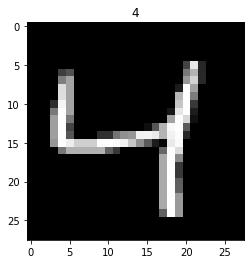

In [5]:
idx = 2
image, label = trainset[idx]
# image is a tensor, needs to be transformed into numpy array
# numpy.squeeze removes axes of length one
plt.imshow(image.numpy().squeeze(), cmap = 'gray')
plt.title(label)

## Task 2 : Splitting Dataset and Setting DataLoader Into Train,Test and Validation Set

In [6]:
# While training a model, we typically want to pass samples in “minibatches”, 
# reshuffle the data at every epoch to reduce model overfitting, and use 
# Python’s multiprocessing to speed up data retrieval.
# DataLoader is an iterable that abstracts this complexity for us in an easy API.
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Split trainset into training and validation set.
valid_size = 0.2
num_train = len(trainset)
split = int(np.floor(valid_size*num_train))
indices = list(range(num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

In [7]:
# Samples elements randomly from a given list of indices, without replacement.
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [8]:
# Already shuffled train and validation set in the sampler.
trainloader = DataLoader(trainset, batch_size = 64, sampler = train_sampler)
validloader = DataLoader(trainset, batch_size = 64, sampler = valid_sampler)
testloader = DataLoader(testset, batch_size = 64, shuffle = True)

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [10]:
print("Batches in Trainsloader: {}".format(len(trainloader)))
print("Batches in Validloader: {}".format(len(validloader)))
print("Batches in Testloader: {}".format(len(testloader)))

print("Examples in Trainsloader: {}".format(len(trainloader.sampler)))
print("Examples in Validloader: {}".format(len(validloader.sampler)))
print("Examples in Testloader: {}".format(len(testloader.dataset)))

Batches in Trainsloader: 750
Batches in Validloader: 188
Batches in Testloader: 157
Examples in Trainsloader: 48000
Examples in Validloader: 12000
Examples in Testloader: 10000


## Task 3 : Creating Neural Network or Model

In [11]:
from torch import nn
import torch.nn.functional as F

class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p = 0.4)
        
    def forward(self, images):
        # [64,1,28,28] -> [64,784]
        images = images.view(images.shape[0], -1)
        
        z1 = self.linear1(images)
        a1 = self.dropout(F.relu(z1))
        
        z2 = self.linear2(a1)
        a2 = self.dropout(F.relu(z2))
        
        z3 = self.linear3(a2)
        a3 = F.log_softmax(z3, dim = 1)
        
        return a3

In [12]:
model = Classifier()
model

Classifier(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [13]:
from torchsummary import summary
summary(model, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
           Dropout-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


## Task 4 : Training Neural Network

In [14]:
from torch import optim
from utils import multiclass_accuracy, view_classify

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)
epochs = 10

In [16]:
for e in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    
    model.train()
    
    for images, labels in trainloader:
        # Gradient methods could work better with log probabilities.
        logps = model(images)
        optimizer.zero_grad()
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    
    for images, labels in validloader:
        logps = model(images)
        # remove log
        ps = torch.exp(logps)
        loss = criterion(logps, labels)
        valid_acc += multiclass_accuracy(ps, labels)
        valid_loss += loss.item()
        
    train_loss = train_loss / len(trainloader)
    valid_loss = valid_loss / len(validloader)
    valid_acc = valid_acc / len(validloader)
    
    print("Epoch: {} Train loss: {:.4f} Valid loss: {:.4f} Valid acc: {}".format(e+1, train_loss, valid_loss, valid_acc))
    

Epoch: 1 Train loss: 0.4295 Valid loss: 0.2381 Valid acc: 0.9294381737709045
Epoch: 2 Train loss: 0.3924 Valid loss: 0.2390 Valid acc: 0.931432843208313
Epoch: 3 Train loss: 0.3783 Valid loss: 0.2259 Valid acc: 0.931432843208313
Epoch: 4 Train loss: 0.3661 Valid loss: 0.2099 Valid acc: 0.9384142160415649
Epoch: 5 Train loss: 0.3582 Valid loss: 0.2405 Valid acc: 0.9250332713127136
Epoch: 6 Train loss: 0.3440 Valid loss: 0.1996 Valid acc: 0.9408244490623474
Epoch: 7 Train loss: 0.3355 Valid loss: 0.1847 Valid acc: 0.9473903179168701
Epoch: 8 Train loss: 0.3362 Valid loss: 0.1992 Valid acc: 0.9438164830207825
Epoch: 9 Train loss: 0.3319 Valid loss: 0.1963 Valid acc: 0.9432346820831299
Epoch: 10 Train loss: 0.3220 Valid loss: 0.1831 Valid acc: 0.9473903179168701


## Task 5 : Evaluating the model

In [18]:
model.eval()

test_loss = 0.0
test_acc = 0.0

for images, labels in testloader:
    logps = model(images)
    ps = torch.exp(logps)
    loss = criterion(logps, labels)
    test_acc += multiclass_accuracy(ps, labels)
    test_loss += loss.item()
        
test_loss = test_loss / len(testloader)
test_acc = test_acc / len(testloader)

print("Test loss: {} Test acc: {}".format(test_loss, test_acc))

Test loss: 0.1686911350412733 Test acc: 0.9501393437385559


Label is 8


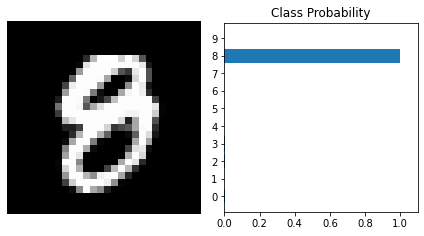

In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

idx = 50
logps = model(images[idx])
ps = torch.exp(logps)

view_classify(images[idx], ps)
print("Label is {}".format(labels[idx]))